# WH all hadronic analysis

Basic implementation of an all-hadronic WH search in the top-W scattering framework:
- Loose Lepton veto
- at least 2 jets
- at least one b-tagged jets
- high MET
- veto QCD



In [1]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [2]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()#.reshape(-1, 1)
    except AttributeError:
        return val.flatten()

#os.environ['KERAS_BACKEND'] = 'theano'
#from keras.models import load_model


In [3]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())

10000


In [19]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        ## load the NN
        #self.model = load_model('../ML/data/training.h5')
        #self.stds  = pd.read_json('../ML/data/stds.json').squeeze()
        #self.means = pd.read_json('../ML/data/means.json').squeeze()
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt_baseline" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_baseline" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_baseline" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt_SR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_SR" :           hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_SR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "W_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK8" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_H" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            "WH_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "WH_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "min_dphiJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiJet":        hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiFatJet":     hist.Hist("Counts", dataset_axis, delta_axis),
            
            'mC750_l1':         processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ttW/ttZ':          processor.defaultdict_accumulator(int),
            'WW/WZ/ZZ':         processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        ## Muons
        muon = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt = df['Muon_pt'].content,
            eta = df['Muon_eta'].content,
            phi = df['Muon_phi'].content,
            mass = df['Muon_mass'].content,
            miniPFRelIso_all=df['Muon_miniPFRelIso_all'].content,
            looseId =df['Muon_looseId'].content
            )
        muon = muon[(muon.pt > 10) & (abs(muon.eta) < 2.4) & (muon.looseId) & (muon.miniPFRelIso_all < 0.2)]
        #muon = Collections(df, "Muon", "tightTTH").get() # this needs a fix for DASK
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content
        )
        
        ## Electrons
        electron = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt = df['Electron_pt'].content,
            eta = df['Electron_eta'].content,
            phi = df['Electron_phi'].content,
            mass = df['Electron_mass'].content,
            miniPFRelIso_all=df['Electron_miniPFRelIso_all'].content,
            cutBased=df['Electron_cutBased'].content
            )
        electron = electron[(electron.pt>10) & (abs(electron.eta) < 2.4) & (electron.miniPFRelIso_all < 0.1) &  (electron.cutBased >= 1)]
        #electron = Collections(df, "Electron", "tightTTH").get() # this needs a fix for DASK
        
        ## FatJets
        fatjet = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt = df['FatJet_pt'].content,
            eta = df['FatJet_eta'].content,
            phi = df['FatJet_phi'].content,
            mass = df['FatJet_mass'].content,
            msoftdrop = df["FatJet_msoftdrop"].content,  
            deepTagMD_HbbvsQCD = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            deepTagMD_WvsQCD = df['FatJet_deepTagMD_WvsQCD'].content, 
            deepTag_WvsQCD = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
        leadingFatJets = fatjet[:,:2]
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        htag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        htag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        
        lead_htag = htag[htag.pt.argmax()]
        
        wtag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        wtag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        
        lead_wtag = wtag[wtag.pt.argmax()]
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            jetId = df['Jet_jetId'].content, # https://twiki.cern.ch/twiki/bin/view/CMS/JetID
            #puId = df['Jet_puId'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetID
            btagDeepB = df['Jet_btagDeepB'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X
            #deepJet = df['Jet_'].content # not there yet?
        )
        
        jet       = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        btag      = jet[(jet.btagDeepB>0.4184)]
        light     = jet[(jet.btagDeepB<0.4184)]
        
        ## Get the leading b-jets
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]
        
        leading_jet    = jet[jet.pt.argmax()]
        leading_b      = btag[btag.pt.argmax()]
        
        bb = high_score_btag.choose(2)
        bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)
        
        mtb = mt(btag.pt, btag.phi, met_pt, met_phi)
        
        ## other variables
        ht = jet.pt.sum()
        
        min_dphiJetMet4 = np.arccos(np.cos(jet[:,:4].phi-met_phi)).min()
        
        leadingJets = jet[:,:2]
        dijet = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        #processes = ['mC750_l1', 'WJets', 'QCD', 'TTJets', 'ZNuNu', 'ST', 'ttW/ttZ', 'WW/WZ/ZZ']
        processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu']
        cutflow = Cutflow(output, df, cfg, processes)
        
        cutflow.addRow( 'electron veto',   (electron.counts==0) )
        cutflow.addRow( 'muon veto',   (muon.counts==0) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
        cutflow.addRow( 'njet2',       (jet.counts>=2) )
        cutflow.addRow( 'jetveto',       (jet.counts<=5) )
        cutflow.addRow( 'nbtag',       (btag.counts>=1) )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'min_dphiJetMet4', (min_dphiJetMet4>0.5))
        cutflow.addRow( 'dphiDiJet', (dphiDiJet.min()<2.5) ) # the min doesn't do anything here
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        
        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'HT>400',      (ht>400) )
        cutflow.addRow( 'N_fatjet>0',      (fatjet.counts>0) )
        cutflow.addRow( 'N_htag>0',     (htag.counts>0))
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'N_wtag>0',     (wtag.counts>0))
        
        event_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_htag>0 hard',     (htag_hard.counts>0))
        cutflow.addRow( 'MET>400',     (met_pt>400) )

        # signal enriched selection of events
        signal_selection = cutflow.selection
        
        ### And fill the histograms
        output['MET_pt_baseline'].fill(dataset=dataset, pt=met_pt[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['HT_baseline'].fill(dataset=dataset, ht=ht[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['mtb_min_baseline'].fill(dataset=dataset, mass=mtb[baseline].min().flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        output['MET_pt'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['HT'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['mtb_min'].fill(dataset=dataset, mass=mtb[vetoQCD].min().flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        
        ## N jet and N b without selections on those
        output['N_AK4'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_W'].fill(dataset=dataset, multiplicity=htag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_H'].fill(dataset=dataset, multiplicity=wtag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_AK8'].fill(dataset=dataset, multiplicity=fatjet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       

        output['bb_deltaPhi'].fill(dataset=dataset, delta=bb_deltaPhi[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['bb_deltaR'].fill(dataset=dataset, delta=bb_deltaR[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        output['min_dphiJetMet4'].fill(dataset=dataset, delta=min_dphiJetMet4[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['dphiDiJet'].fill(dataset=dataset, delta=dphiDiJet[baseline].min().flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        ## Higgs and W pt
        output['lead_AK8_pt'].fill(dataset=dataset, pt=fatjet[(baseline & (fatjet.counts>0))].pt.max().flatten(), weight=df['weight'][(baseline & (fatjet.counts>0))]*cfg['lumi'])
        output['dphiDiFatJet'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline & (fatjet.counts>1))].min().flatten(), weight=df['weight'][(baseline & (fatjet.counts>1))]*cfg['lumi'])

        output['H_pt'].fill(dataset=dataset, pt=lead_htag[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['H_eta'].fill(dataset=dataset, eta=lead_htag[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['W_pt'].fill(dataset=dataset, pt=lead_wtag[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['W_eta'].fill(dataset=dataset, eta=lead_wtag[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['WH_deltaPhi'].fill(dataset=dataset, delta=wh_deltaPhi[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['WH_deltaR'].fill(dataset=dataset, delta=wh_deltaR[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['MET_pt_SR'].fill(dataset=dataset, pt=met_pt[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['HT_SR'].fill(dataset=dataset, ht=ht[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['mtb_min_SR'].fill(dataset=dataset, mass=mtb[event_selection].min().flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        
        return output

    def postprocess(self, accumulator):
        return accumulator


In [20]:
runLocal = False


if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client('tcp://169.228.130.5:27879')

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

<Client: 'tcp://169.228.130.5:27879' processes=50 threads=50, memory=150.00 GB>


In [23]:
overwrite = True
small = False

tag = '0p1p20'
#tag = '0p1p16/2018'

fileset_WH   = {'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                'WJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WJetsToLNu*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root'),
                'TTJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/TTJets*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZJetsToNuNu*/*.root'),
                'ST': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST*/*.root'),
                'ttW/ttZ': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttZJets*/*.root'),
                'WW/WZ/ZZ': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WW*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WZ*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2L2Nu*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2Q2Nu*/*.root')
                }

fileset_WH_merge = {'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                'LL': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WJetsToLNu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/TTJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WW*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZJetsToNuNu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttZJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WZ*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2L2Nu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2Q2Nu*/*.root')
                }


# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_small' if small else 'WH'

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = {
                    'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                    'LL': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root')[:2],
                    'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root')[:2]}
        workers = 4
    else:
        fileset = fileset_WH_merge
        workers = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

In [24]:
# Cutflow
from Tools.helpers import getCutFlowTable

#processes = ['mC750_l1', 'WJets', 'QCD', 'TTJets', 'ZNuNu', 'ST', 'ttW/ttZ', 'WW/WZ/ZZ']
processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu']
lines     = ['entry']
lines    += ['electron veto', 'muon veto',  'MET>250', 'njet2', 'jetveto', 'nbtag', 'min_dphiJetMet4', 'dphiDiJet', 'dphiDiFatJet',  'HT>400', 'N_fatjet>0', 'N_htag>0',  'N_fatjet>1', 'N_wtag>0', 'N_htag>0 hard',  'MET>400']
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='mC750_l1')
df

,mC750_l1,LL,QCD,ZNuNu,S/B
entry,298.0 +/- 1.4,7743000.0 +/- 18000.0,3910000.0 +/- 28000.0,1808000.0 +/- 1000.0,0.0000
electron veto,296.1 +/- 1.4,5988000.0 +/- 16000.0,3893000.0 +/- 28000.0,1792000.0 +/- 1000.0,0.0000
muon veto,293.1 +/- 1.4,3909000.0 +/- 13000.0,3133000.0 +/- 16000.0,1773000.0 +/- 1000.0,0.0000
MET>250,267.4 +/- 1.3,1556000.0 +/- 8000.0,907900.0 +/- 6300.0,813100.0 +/- 500.0,0.0001
njet2,266.7 +/- 1.3,1479000.0 +/- 8000.0,896100.0 +/- 5800.0,756600.0 +/- 500.0,0.0001
jetveto,239.2 +/- 1.3,1392000.0 +/- 8000.0,827200.0 +/- 5700.0,743400.0 +/- 500.0,0.0001
nbtag,197.1 +/- 1.2,260800.0 +/- 2700.0,187100.0 +/- 2900.0,79900.0 +/- 160.0,0.0004
min_dphiJetMet4,173.0 +/- 1.1,127700.0 +/- 1900.0,3504.0 +/- 1180.0,65640.0 +/- 150.0,0.0009
dphiDiJet,153.5 +/- 1.0,109000.0 +/- 1700.0,1469.0 +/- 257.0,59840.0 +/- 140.0,0.0009
dphiDiFatJet,150.8 +/- 1.0,107600.0 +/- 1700.0,1324.0 +/- 253.0,59550.0 +/- 140.0,0.0009


In [25]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,mC750_l1,LL,QCD,ZNuNu
entry,1.000,1.000,1.000,1.000
electron veto,0.994,0.773,0.996,0.991
muon veto,0.990,0.653,0.805,0.990
MET>250,0.913,0.398,0.290,0.459
njet2,0.997,0.950,0.987,0.931
jetveto,0.897,0.941,0.923,0.983
nbtag,0.824,0.187,0.226,0.107
min_dphiJetMet4,0.877,0.490,0.019,0.821
dphiDiJet,0.888,0.853,0.419,0.912
dphiDiFatJet,0.982,0.987,0.901,0.995


## Backgrounds

We do have three main background categories:
- Lost lepton (everything W related: W+jets, single top, tt, ttW, WW)
  - This will be the main background
  - M_T(b, MET), deltaPhi/deltaR between b candidates against top quark backgrounds 
- Z->nunu (everything Z related: Z->nunu, ttZ, WZ)
  - Hard to tackle. Let's think about something
- QCD <-- should be gone with delta Phi cuts and large MET


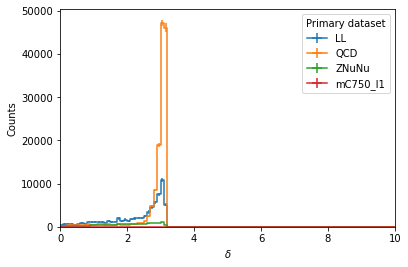

In [72]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

histogram = output['dphiDiFatJet']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

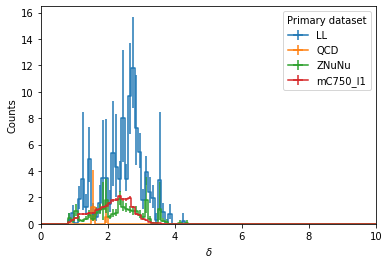

In [80]:
histogram = output['WH_deltaR']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

In [8]:

import re
notdata = re.compile('(?!pseudodata)')
notsignal = re.compile('(?!tW_scattering)')

def myRebin(var, nbins, binsize, threshold):
    #values = output[var]['tW_scattering'].sum("dataset").values()[()]
    values = output[var][notsignal].sum("dataset").values()[()]
    bin_boundaries = [0]
    last_index = 0

    for i in range(nbins): # loop over the bins like a cave man
        #output['leadingForward_p']['tW_scattering'].sum("dataset").values()[()]
        if values[last_index:i].sum() > threshold:
            bin_boundaries.append(i)
            last_index = i
    return np.array(bin_boundaries)*binsize

We can probably scale up the signal x-sec by ~1.5 (assuming 12% of the inclusive ttW x-sec, compared to the x-sec we currently use 0.12\*0.61/0.0478).
This increases S/B to about 0.10, with ttbar still being the largest contribution of almost 100 events.
Can we use a tighter ID (e.g. ttH/V leptonMVA), or are we missing something?

The theory paper has a lower ttbar rate, but probably a tighter lepton ID (similar signal yield for 300/fb as we have for 137/fb).

We should check:
- which ttX contribution is the largest
- use ttH lepton ID -> should be easy to implement now
- add some plots

In [166]:
from plots.helpers import *
bins = {\
    'N_AK4':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK4 jet}$', 6, -0.5, 5.5)},
    'N_AK8':    {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{AK8 jet}$', 5, -0.5, 4.5)},
    'N_b':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{b-tag}$', 5, -0.5, 4.5)},
    'N_H':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{H-tag}$', 5, -0.5, 4.5)},
    'N_W':      {'axis': 'multiplicity',  'overflow':'over',  'bins': hist.Bin('multiplicity', r'$N_{W-tag}$', 5, -0.5, 4.5)},

    'MET_pt':   {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T}^{miss}\ (GeV)$', 20, 0, 800)},
    'HT':       {'axis': 'ht',      'overflow':'over',  'bins': hist.Bin('pt', r'$H_{T} (AK4 jets) \ (GeV)$', 25, 0, 2000)},    
    'W_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (W-tag)$', 8, 200, 600)},
    'W_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (W-tag)$', 15, -5.5, 5.5)},
    'H_pt':     {'axis': 'pt',      'overflow':'over',  'bins': hist.Bin('pt', r'$p_{T} (H-tag)$', 8, 200, 600)},
    'H_eta':    {'axis': 'eta',     'overflow':'over',  'bins': hist.Bin('eta', r'$\eta (H-tag)$', 15, -5.5, 5.5)},

    'dphiDiFatJet': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK8)$', 30, 0, 3)},
    'dphiDiJet':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (AK4)$', 30, 0, 3)},
    'WH_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (WH)$', 6, 0, 3)},
    'WH_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (WH)$', 10, 0, 5)},
    'bb_deltaPhi':  {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (bb)$', 30, 0, 3)},
    'bb_deltaR':    {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta R (bb)$', 10, 0, 5)},
    'min_dphiJetMet4': {'axis': 'delta',          'overflow':'over',  'bins': hist.Bin('delta', r'$\Delta \phi (j, p_{T}^{miss})$', 30, 0, 3)},
        
    'mtb_min':      {'axis': 'mass',  'overflow':'over',  'bins': hist.Bin('pt', r'$min M_{T} (b, p_{T}^{miss}) \ (GeV)$', 25, 0, 500)},
    'lead_AK8_pt':  {'axis': 'pt',    'overflow':'over',  'bins': hist.Bin('pt', r'$p{T} (lead. AK8) \ (GeV)$', 20, 0, 1000)},
    }

In [167]:
from plots.helpers import *

colors = {
    'mC750_l1': '#FF595E',
    'LL': '#1982C4',
    'ZNuNu': '#FFCA3A',
    'QCD': '#8AC926',
    }

my_labels = {
    'mC750_l1': 'WH (750,1)',
    'LL': 'Lost Lepton',
    'ZNuNu': r'$Z \rightarrow inv$',
    'QCD': 'QCD',
    'pseudodata': 'Pseudo-data',
    'uncertainty': 'Uncertainty',
}

def saveFig( fig, ax, rax, path, name, scale='linear', shape=False, y_max=-1 ):
    outdir = os.path.join(path,scale)
    finalizePlotDir(outdir)
    ax.set_yscale(scale)
    ax.set_ylabel('Events')

    if scale == 'linear':
        if y_max<0 or True:
            pass
        else:
            ax.set_ylim(0, 1 if shape else 1.2*y_max)
    else:
        if y_max<0 and not shape:
            pass
        else:
            ax.set_ylim(0.000005 if shape else 0.05, 3 if shape else 300*y_max)

    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for handle, label in zip(handles, labels):
        #print (handle, label)
        try:
            new_labels.append(my_labels[label])
            if not label=='pseudodata':
                handle.set_color(colors[label])
        except:
            pass

    if rax:
        plt.subplots_adjust(hspace=0)
        rax.set_ylabel('Obs./Pred.')
        rax.set_ylim(0.5,1.5)

    ax.legend(title='',ncol=2,handles=handles, labels=new_labels, frameon=False)

    fig.text(0., 0.995, '$\\bf{CMS}$', fontsize=20,  horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.15, 1., '$\\it{Simulation}$', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )
    fig.text(0.8, 1., '13 TeV', fontsize=14, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes )

    fig.savefig(os.path.join(outdir, "{}.pdf".format(name)))
    fig.savefig(os.path.join(outdir, "{}.png".format(name)))
    #ax.clear()

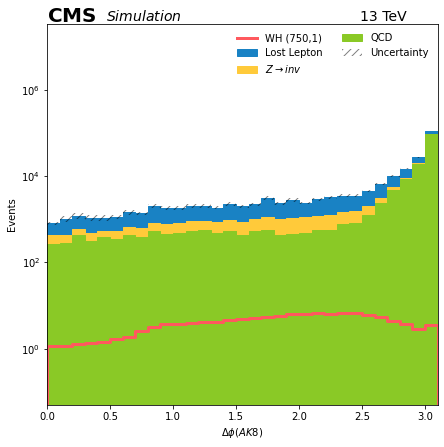

In [171]:
# Make some of the plots. If they look weird, rerun the notebook again - we use a mplhep style for the NLL scan below.

plotDir = '/home/users/dspitzba/public_html/dump/WH_had/'
finalizePlotDir(plotDir)

if True:
    #name = 'leadingForward_p'
    name = 'dphiDiFatJet'

    #print (name)
    skip = False
    
    # load the cached results
    #output = cache.get('simple_output')
    histogram = output[name]

    axis = bins[name]['axis']
    #print (name, axis)
    histogram = histogram.rebin(axis, bins[name]['bins'])

    y_max = histogram.sum("dataset").values(overflow='all')[()].max()
    y_over = histogram.sum("dataset").values(overflow='all')[()][-1]

    # get pseudo data
    if False:
        if not histogram['pseudodata'].values():
            print ("Getting pseudo-data")
            bin_values = histogram.axis(axis).centers(overflow=bins[name]['overflow'])
            poisson_means = histogram.sum('dataset').values(overflow=bins[name]['overflow'])[()]
            values = np.repeat(bin_values, np.random.poisson(np.maximum(np.zeros(len(poisson_means)), poisson_means)))
            if axis == 'pt':
                histogram.fill(dataset='pseudodata', pt=values)
            elif axis == 'p':
                histogram.fill(dataset='pseudodata', p=values)
            elif axis == 'delta':
                histogram.fill(dataset='pseudodata', delta=values)
            elif axis == 'eta':
                histogram.fill(dataset='pseudodata', eta=values)
            elif axis == 'mass':
                histogram.fill(dataset='pseudodata', mass=values)
            elif axis == 'multiplicity':
                histogram.fill(dataset='pseudodata', multiplicity=values)
            elif axis == 'ht':
                histogram.fill(dataset='pseudodata', ht=values)
            elif axis == 'norm':
                histogram.fill(dataset='pseudodata', norm=values)
            
            # update the cache
            output[name] = histogram
            #cache['simple_output']  = output
            #cache.dump()
            
        else:
            print ("Pseudo-data found in cache")

    
    import re
    bkgonly = re.compile('(?!mC750_l1)')
    notdata = re.compile('(?!pseudodata)')
    notsignal = re.compile('(?!mC750_l1)')

    #fig, (ax, rax) = plt.subplots(2, 1, figsize=(7,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
    fig, ax = plt.subplots(1,1,figsize=(7,7))
    
    # get axes
    hist.plot1d(histogram[bkgonly], overlay="dataset", ax=ax, stack=True, overflow=bins[name]['overflow'], clear=False, line_opts=None, fill_opts=fill_opts, error_opts=error_opts, order=['QCD', 'ZNuNu', 'LL']) #error_opts??
    hist.plot1d(histogram['mC750_l1'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], line_opts={'linewidth':3}, clear=False)
    #hist.plot1d(histogram['pseudodata'], overlay="dataset", ax=ax, overflow=bins[name]['overflow'], error_opts=data_err_opts, clear=False)

    ## build ratio
    #hist.plotratio(
    #    num=histogram['pseudodata'].sum("dataset"),
    #    denom=histogram[bkgonly].sum("dataset"),
    #    ax=rax,
    #    error_opts=data_err_opts,
    #    denom_fill_opts={},
    #    guide_opts={},
    #    unc='num',
    #    overflow=bins[name]['overflow']
    #)


    for l in ['log']:
        saveFig(fig, ax, None, plotDir, name, scale=l, shape=False, y_max=y_max)


## Make some data cards and run the likelihood fit for the M(jj) distribution

As a test we will use the 10 bins of the M(jj) distribution to extract a likelihood ratio. We should be able to find a better variable than M(jj), this is more a proof of concept.

First, we extract the histograms from the processor output and store them in a root file. Then, we create a data card, add some mock-up systematic uncertainties and run the fit with combine.

In [13]:
from Tools.dataCard import *

In [14]:
# get the histograms to write into a root file, which subsequently is picked up by combine
# in order to also get the content of the overflow bins we use a private version of export1d

from Tools.helpers import export1d

def makeCardFromHist(hist_name, nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext=''):
    print ("Writing cards using histogram:", hist_name)
    card_dir = os.path.expandvars('$TWHOME/data/cards/')
    if not os.path.isdir(card_dir):
        os.makedirs(card_dir)
    
    data_card = card_dir+hist_name+ext+'_card.txt'
    shape_file = card_dir+hist_name+ext+'_shapes.root'
    
    histogram = output[hist_name]
    #histogram = histogram.rebin('mass', bins[hist_name]['bins'])
    
    # scale some processes
    scales = { 
        'ttbar': nonprompt_scale, 
        'tW_scattering': signal_scale,
        'TTW': bkg_scale, # only scale the most important backgrounds
        'TTZ': bkg_scale,
        'TTH': bkg_scale,
    }
    histogram.scale(scales, axis='dataset')
    
    #observation = hist.export1d(histogram['pseudodata'].integrate('dataset'), overflow=overflow)
    observation = export1d(histogram[notdata].integrate('dataset'), overflow=overflow)
    tw          = export1d(histogram['tW_scattering'].integrate('dataset'), overflow=overflow)
    onlyttx     = re.compile('(TTW|TTZ|TTH|TTTT|diboson|DY)')
    bkg         = export1d(histogram[onlyttx].integrate('dataset'), overflow=overflow)
    nonprompt   = export1d(histogram['ttbar'].integrate('dataset'), overflow=overflow)
    
    file = uproot.recreate(shape_file, compression=uproot.ZLIB(4))
    
    file["signal"]    = tw
    file["nonprompt"] = nonprompt
    file["bkg"]       = bkg
    file["data_obs"]  = observation
    
    # Get the total yields to write into a data card
    totals = {}
    
    totals['signal']      = histogram['tW_scattering'].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['bkg']         = histogram[onlyttx].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['nonprompt']   = histogram['ttbar'].integrate('dataset').values(overflow=overflow)[()].sum()
    #totals['observation'] = histogram['pseudodata'].integrate('dataset').values(overflow=overflow)[()].sum()
    totals['observation'] = histogram[notdata].integrate('dataset').values(overflow=overflow)[()].sum()
    
    print ("{:30}{:.2f}".format("Signal expectation:",totals['signal']) )
    print ("{:30}{:.2f}".format("Non-prompt background:",totals['nonprompt']) )
    print ("{:30}{:.2f}".format("t(t)X(X)/rare background:",totals['bkg']) )
    print ("{:30}{:.2f}".format("Observation:", totals['observation']) )
    
    
    # set up the card
    card = dataCard()
    card.reset()
    card.setPrecision(3)
    
    # add the uncertainties (just flat ones for now)
    card.addUncertainty('lumi', 'lnN')
    card.addUncertainty('ttx', 'lnN')
    card.addUncertainty('fake', 'lnN')
    
    # add the single bin
    card.addBin('Bin0', [ 'bkg', 'nonprompt' ], 'Bin0')
    card.specifyExpectation('Bin0', 'signal', totals['signal'] )
    card.specifyExpectation('Bin0', 'bkg', totals['bkg'] )
    card.specifyExpectation('Bin0', 'nonprompt', totals['nonprompt'] )
    
    # set uncertainties
    card.specifyUncertainty('ttx', 'Bin0', 'bkg', 1.15 )
    card.specifyUncertainty('fake', 'Bin0', 'nonprompt', 1.20 )
    card.specifyFlatUncertainty('lumi', 1.03)
    
    # observation
    card.specifyObservation('Bin0', int(round(totals['observation'],0)))
    
    print ("Done.\n")
    
    return card.writeToFile(data_card, shapeFile=shape_file)


In [15]:
card_SR = makeCardFromHist('mjj_max', overflow='all')
#card_SR = makeCardFromHist('mjj_max', nonprompt_scale=0.5, signal_scale=0.12*0.61/0.0478, bkg_scale=1, overflow='all')
card_baseline = makeCardFromHist('leadingForward_p', overflow='all', ext='_baseline')

Writing cards using histogram: mjj_max
Signal expectation:           13.51
Non-prompt background:        30.99
t(t)X(X)/rare background:     108.99
Observation:                  153.49
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/mjj_max_card.txt
Writing cards using histogram: leadingForward_p
Signal expectation:           13.51
Non-prompt background:        30.99
t(t)X(X)/rare background:     108.99
Observation:                  153.49
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/leadingForward_p_baseline_card.txt


In [16]:
card = dataCard()
results_SR = card.nllScan(fname=card_SR, rmin=0, rmax=5, npoints=101)
results_baseline = card.nllScan(fname=card_baseline, rmin=0, rmax=5, npoints=101)

Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/processor/b77fe965-b94c-40b1-af08-8b2c05e09663
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/processor/6626d7d2-eefe-4d11-8e53-4595275e40b5


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


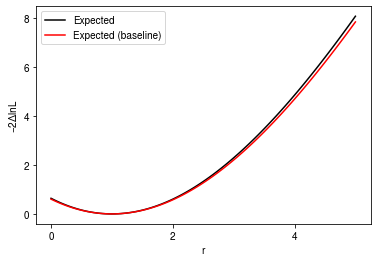

In [17]:
import mplhep
#plt.style.use(mplhep.style.CMS)

plt.figure()

plt.plot(results_SR['r'][1:], results_SR['deltaNLL'][1:]*2, label='Expected', c='black')#, linewidths=2)
plt.plot(results_baseline['r'][1:], results_baseline['deltaNLL'][1:]*2, label='Expected (baseline)', c='red')#, linewidths=2)
plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()



plt.style.use(mplhep.cms.style.ROOT)
#mplhep.cms.cmslabel(data=False, paper=False, year='Run2')

#mplhep.mpl_magic() ## doesn't really work.

plt.show()

In [ ]:
# clean up in case some combine jobs crashed.
card.cleanUp()

In [25]:
card_baseline

'/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/mjj_max_card.txt'

In [22]:
results_baseline

,r,deltaNLL,nll,nll0
entry,,,,
0,1.002666,0.000000,-1.107772,-2.131628e-14
1,0.000000,0.242279,-1.107772,-2.131628e-14
2,0.050000,0.218689,-1.107772,-2.131628e-14
3,0.100000,0.196293,-1.107772,-2.131628e-14
4,0.150000,0.175095,-1.107772,-2.131628e-14
5,0.200000,0.155099,-1.107772,-2.131628e-14
6,0.250000,0.136307,-1.107772,-2.131628e-14
7,0.300000,0.118723,-1.107772,-2.131628e-14
8,0.350000,0.102349,-1.107772,-2.131628e-14
